In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
from random import uniform

In [ ]:
class PhysicsInformedNN():
    def __init__(self, X_u, u, X_f):
        # x & t from boundary conditions:
        self.x_u = torch.tensor(X_u[:, 0].reshape(-1, 1),
                                dtype=torch.float32,
                                requires_grad=True)
        self.t_u = torch.tensor(X_u[:, 1].reshape(-1, 1),
                                dtype=torch.float32,
                                requires_grad=True)

        # x & t from collocation points:
        self.x_f = torch.tensor(X_f[:, 0].reshape(-1, 1),
                                dtype=torch.float32,
                                requires_grad=True)
        self.t_f = torch.tensor(X_f[:, 1].reshape(-1, 1),
                                dtype=torch.float32,
                                requires_grad=True)

        # boundary solution:
        self.u = torch.tensor(u, dtype=torch.float32)

        # zero vector:
        self.null =  torch.zeros((self.x_f.shape[0], 1))

        # initialize
        self.create_net()
    

        # updates the weights and b:
        self.optimizer = torch.optim.LBFGS(self.net.parameters(),
                                    lr=1,
                                    max_iter=50000,
                                    max_eval=50000,
                                    history_size=50,
                                    tolerance_grad=1e-05,
                                    tolerance_change=0.5 * np.finfo(float).eps,
                                    line_search_fn="strong_wolfe")

        #  MSE loss:
        self.loss = nn.MSELoss()

        # loss :
        self.ls = 0

        # iteration number:
        self.iter = 0

    def create_net(self):
        self.net = nn.Sequential(
            nn.Linear(2, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 1))

    def init_weights(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_normal_(m.weight, 0.1)
            m.bias.data.fill_(0.001)
        
    def net_u(self, x, t):
        u = self.net( torch.hstack((x, t)) )
        return u

    def net_f(self, x, t):
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True)[0]
        
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True)[0]
        
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True)[0]

        f = u_t + (u * u_x) - (nu * u_xx)

        return f

    def plot(self):
        
        
        import matplotlib.pyplot as plt
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        
        x = torch.linspace(-1, 1, 200)
        t = torch.linspace( 0, 1, 100)

        # x & t grids:
        X, T = torch.meshgrid(x, t)

        # x & t columns:
        xcol = X.reshape(-1, 1)
        tcol = T.reshape(-1, 1)

        # one large column:
        usol = self.net_u(xcol, tcol)

        # reshape solution:
        U = usol.reshape(x.numel(), t.numel())

        # transform to numpy:
        xnp = x.numpy()
        tnp = t.numpy()
        Unp = U.detach().numpy()

        # plot:
        fig = plt.figure(figsize=(9, 4.5))
        ax = fig.add_subplot(111)

        h = ax.imshow(Unp,
                      interpolation='nearest',
                      cmap='rainbow', 
                      extent=[tnp.min(), tnp.max(), xnp.min(), xnp.max()], 
                      origin='lower', aspect='auto')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.10)
        cbar = fig.colorbar(h, cax=cax)
        cbar.ax.tick_params(labelsize=10)
        plt.show()

    def closure(self):
        # reset gradients to zero:
        self.optimizer.zero_grad()
        
        # u & f predictions:
        u_prediction = self.net_u(self.x_u, self.t_u)
        f_prediction = self.net_f(self.x_f, self.t_f)

        # losses:
        u_loss = self.loss(u_prediction, self.u)
        f_loss = self.loss(f_prediction, self.null)
        self.ls = u_loss + f_loss

        # derivative with respect to net's weights:
        self.ls.backward()

        # increase iteration count:
        self.iter += 1

        # print report:
        if not self.iter % 100:
            print('Epoch: {0:}, Loss: {1:6.3f}'.format(self.iter, self.ls))

        return self.ls
        
    def train(self):
        """ training loop """
        self.net.train()
        self.optimizer.step(self.closure)
        pinn.plot()
        plt.show
        plt.plot(pinn.iter,pinn.ls)
        plt.show

if __name__ == '__main__' :

    nu = 0.01 / np.pi         # constant in the diff. equation
    N_u = 100                 # number of data points in the boundaries
    N_f = 10000               # number of collocation points

    # X_u_train: a set of pairs (x, t) located at:
        # x =  1, t = [0,  1]
        # x = -1, t = [0,  1]
        # t =  0, x = [-1, 1]
    x_upper = np.ones((N_u//4, 1), dtype=float)
    x_lower = np.ones((N_u//4, 1), dtype=float) * (-1)
    t_zero = np.zeros((N_u//2, 1), dtype=float)

    t_upper = np.random.rand(N_u//4, 1)
    t_lower = np.random.rand(N_u//4, 1)
    x_zero = (-1) + np.random.rand(N_u//2, 1) * (1 - (-1))

    # stack uppers, lowers and zeros:
    X_upper = np.hstack( (x_upper, t_upper) )
    X_lower = np.hstack( (x_lower, t_lower) )
    X_zero = np.hstack( (x_zero, t_zero) )

    # each one of these three arrays haS 2 columns, 
    # now we stack them vertically, the resulting array will also have 2 
    # columns and 100 rows:
    X_u_train = np.vstack( (X_upper, X_lower, X_zero) )

    # shuffle X_u_train:
    index = np.arange(0, N_u)
    np.random.shuffle(index)
    X_u_train = X_u_train[index, :]
    
    # make X_f_train:
    X_f_train = np.zeros((N_f, 2), dtype=float)
    for row in range(N_f):
        x = uniform(-1, 1)  # x range
        t = uniform( 0, 1)  # t range

        X_f_train[row, 0] = x 
        X_f_train[row, 1] = t

    # add the boundary points to the collocation points:
    X_f_train = np.vstack( (X_f_train, X_u_train) )

    # make u_train
    u_upper =  np.zeros((N_u//4, 1), dtype=float)
    u_lower =  np.zeros((N_u//4, 1), dtype=float) 
    u_zero = -np.sin(np.pi * x_zero)  

    # stack them in the same order as X_u_train was stacked:
    u_train = np.vstack( (u_upper, u_lower, u_zero) )

    # match indices with X_u_train
    u_train = u_train[index, :]

    # pass data sets to the PINN:
    pinn = PhysicsInformedNN(X_u_train, u_train, X_f_train)

    pinn.train()
    pinn.plot()
    plt.plot(pinn.iter,pinn.ls)
    

Epoch: 100, Loss:  0.076
Epoch: 200, Loss:  0.030
Epoch: 300, Loss:  0.014
Epoch: 400, Loss:  0.006
Epoch: 500, Loss:  0.003
Epoch: 600, Loss:  0.002


2


pinn.store


/Users/rishi/miniconda3/envs/hwenv/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1659484612588/work/aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


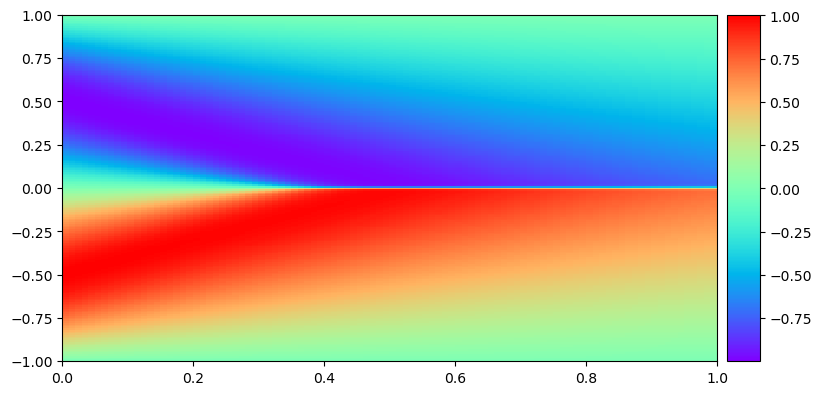

In [6]:
pinn.plot()